In [5]:
pip install pmdarima

In [6]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import warnings
from datetime import datetime
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [7]:
# Load the data
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Nat_Gas.csv")
df['Dates'] = pd.to_datetime(df['Dates'])
df.set_index('Dates', inplace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Use auto_arima to find the best model
model = auto_arima(df, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

# Forecast for the next 12 months
forecast = model.predict(n_periods=12)
forecast_index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=37.147, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=48.334, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=38.394, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=42.336, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=46.741, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=39.069, Time=1.61 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=38.330, Time=3.47 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=36.109, Time=0.78 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=53.197, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=53.566, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=53.701, Time=0.74 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=53.674, Time=1.05 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=51.953, Ti

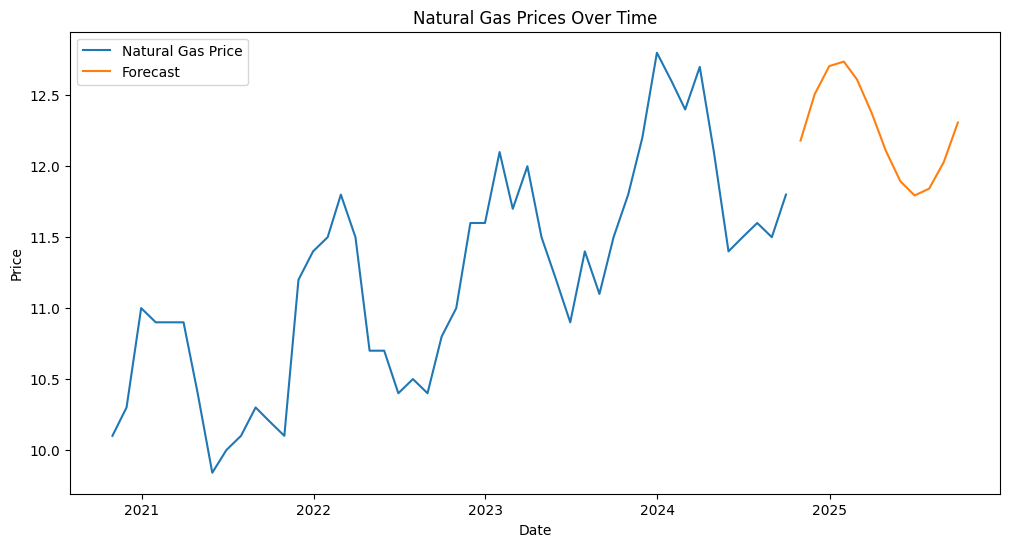

In [9]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df, label='Natural Gas Price')
plt.plot(forecast_df, label='Forecast')
plt.title('Natural Gas Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [10]:
# Function to estimate the price for any given date
def estimate_price(date_str):
    date = pd.to_datetime(date_str)

    if date in df.index:
        return df.loc[date].values[0]
    elif date in forecast_df.index:
        return forecast_df.loc[date].values[0]
    else:
        if date < df.index[0]:
            return np.nan  # Date is out of historical data bounds
        return np.interp(date.toordinal(), df.index.to_series().map(pd.Timestamp.toordinal), df.values.flatten())


In [11]:
# Function to price the contract
def price_contract(injection_dates, withdrawal_dates, injection_rate, withdrawal_rate, max_volume, storage_cost_per_month, injection_withdrawal_cost, transport_cost):
    total_value = 0
    total_cost = 0
    total_volume = 0

    # Calculate the volume injected and the associated costs
    for injection_date in injection_dates:
        price = estimate_price(injection_date)
        volume = injection_rate
        if total_volume + volume > max_volume:
            volume = max_volume - total_volume  # Ensure we do not exceed storage capacity
        total_cost += volume * price + injection_withdrawal_cost + transport_cost
        total_volume += volume

    # Calculate the volume withdrawn and the associated revenue
    for withdrawal_date in withdrawal_dates:
        price = estimate_price(withdrawal_date)
        volume = withdrawal_rate
        if total_volume - volume < 0:
            volume = total_volume  # Ensure we do not withdraw more than what we have
        total_value += volume * price - injection_withdrawal_cost - transport_cost
        total_volume -= volume

    # Calculate the storage costs
    num_months = len(set([datetime.strptime(date, "%Y-%m-%d").strftime("%Y-%m") for date in injection_dates + withdrawal_dates]))
    total_cost += num_months * storage_cost_per_month

    # Calculate the net value of the contract
    contract_value = total_value - total_cost
    return contract_value


In [12]:
# Interactive input from user
def get_user_inputs():
    print("Enter injection dates (YYYY-MM-DD), separated by commas:")
    injection_dates = input().split(',')

    print("Enter withdrawal dates (YYYY-MM-DD), separated by commas:")
    withdrawal_dates = input().split(',')

    injection_rate = float(input("Enter the injection rate (MMBtu): "))
    withdrawal_rate = float(input("Enter the withdrawal rate (MMBtu): "))
    max_volume = float(input("Enter the maximum storage volume (MMBtu): "))
    storage_cost_per_month = float(input("Enter the storage cost per month (USD): "))
    injection_withdrawal_cost = float(input("Enter the injection/withdrawal cost (USD per operation): "))
    transport_cost = float(input("Enter the transport cost (USD per operation): "))

    return injection_dates, withdrawal_dates, injection_rate, withdrawal_rate, max_volume, storage_cost_per_month, injection_withdrawal_cost, transport_cost


In [13]:
# Get inputs from the user
injection_dates, withdrawal_dates, injection_rate, withdrawal_rate, max_volume, storage_cost_per_month, injection_withdrawal_cost, transport_cost = get_user_inputs()

# Calculate the contract value
contract_value = price_contract(injection_dates, withdrawal_dates, injection_rate, withdrawal_rate, max_volume, storage_cost_per_month, injection_withdrawal_cost, transport_cost)
print(f"The value of the contract is: ${contract_value:.2f}")


Enter injection dates (YYYY-MM-DD), separated by commas:
2024-08-21
Enter withdrawal dates (YYYY-MM-DD), separated by commas:
2024-12-22
Enter the injection rate (MMBtu): 3
Enter the withdrawal rate (MMBtu): 4
Enter the maximum storage volume (MMBtu): 5
Enter the storage cost per month (USD): .5
Enter the injection/withdrawal cost (USD per operation): .1
Enter the transport cost (USD per operation): .1
The value of the contract is: $-0.60
